In [1]:
import torch
import torch.nn  as  nn  
import torch.optim as  optim
from    torchvision import datasets,  transforms
import seaborn as  sns   
import matplotlib.pyplot as  plt
import sys
import numpy as np

In [ ]:
# Download the MNIST dataset
transform = transforms.ToTensor()  
train_dataset = datasets.MNIST(root   ='./data',  train=True   ,  download=True   , transform=transform) 
test_dataset = datasets.MNIST(root   ='./data',  train=False,  download=True   , transform=transform) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64 ,  shuffle=True   ) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [3]:

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Output the dimensions of train and test datasets
train_data_shape = train_dataset.data.shape
test_data_shape = test_dataset.data.shape

# The size of the images can be inferred from the shape of one image
image_size = train_dataset.data[0].shape

print("Train Dataset Shape:", train_data_shape)
print("Test Dataset Shape:", test_data_shape)
print("Image Size:", image_size)


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Train Dataset Shape: torch.Size([60000, 28, 28])
Test Dataset Shape: torch.Size([10000, 28, 28])
Image Size: torch.Size([28, 28])


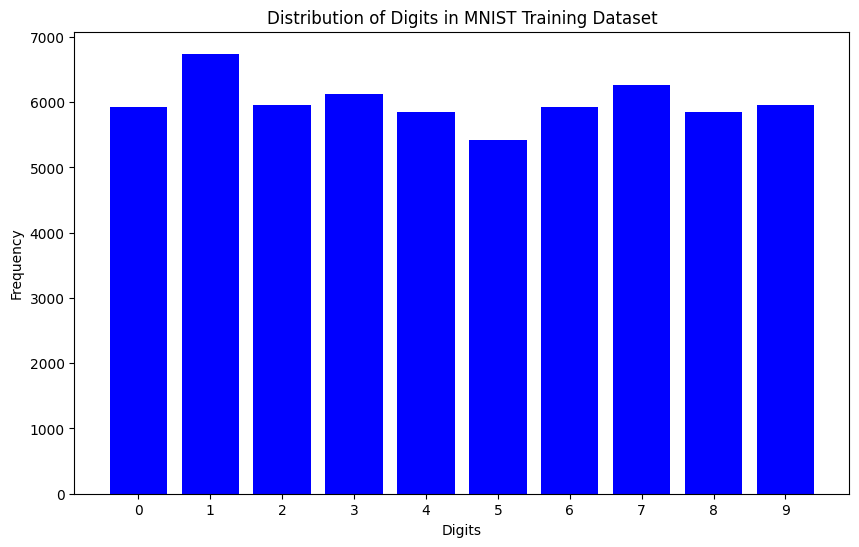

In [4]:

# Get the distribution of digits in the training dataset
digit_counts = np.bincount(train_dataset.targets.numpy())

# Define the labels for each digit (0-9)
digit_labels = np.arange(10)

# Plotting the digit distribution
plt.figure(figsize=(10, 6))
plt.bar(digit_labels, digit_counts, color='blue')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Distribution of Digits in MNIST Training Dataset')
plt.xticks(digit_labels)
plt.show()


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [6]:

# Define model
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        ## CONV LAYER
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=0) # Output size   :([64, 64, 26, 26])
        self.pool = nn.MaxPool2d(kernel_size=2) # Output size   :([64, 64, 13, 13])

        self.fc1 = nn.Linear(in_features= 64 * 13 * 13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x) # add dropout layer
        x = self.relu(self.fc2(x))
        x = self.dropout(x) # add dropout layer
        x = self.relu(self.fc3(x))
        return x
    
model = MyNetwork().to(device)
print(model)

MyNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


Epoch [1/5], Training Loss: 0.0272, Validation Loss: 0.0479, Accuracy: 98.45%
Epoch [2/5], Training Loss: 0.0214, Validation Loss: 0.0507, Accuracy: 98.53%
Epoch [3/5], Training Loss: 0.0162, Validation Loss: 0.0455, Accuracy: 98.56%
Epoch [4/5], Training Loss: 0.0122, Validation Loss: 0.0469, Accuracy: 98.45%
Epoch [5/5], Training Loss: 0.0091, Validation Loss: 0.0475, Accuracy: 98.52%


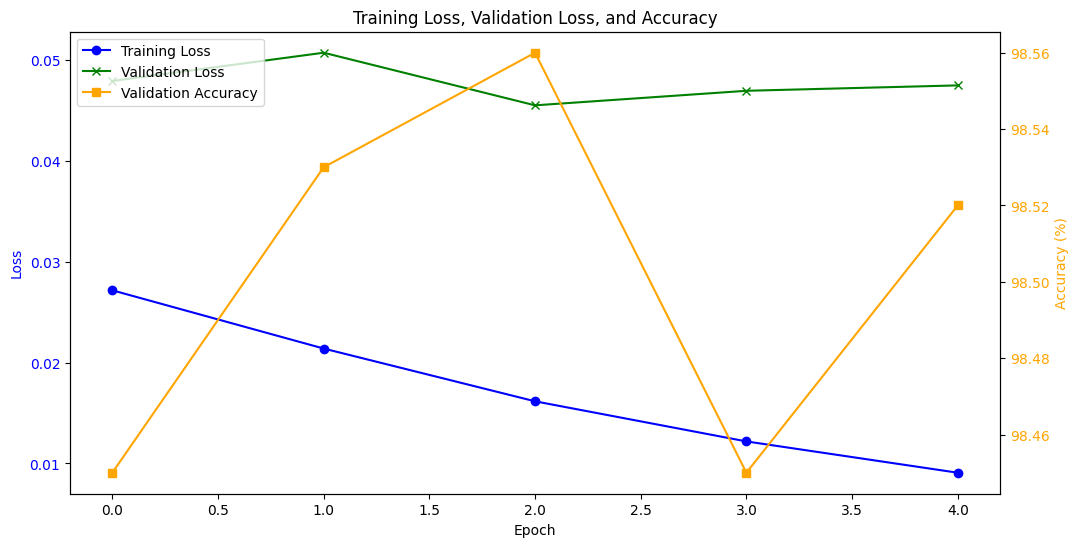

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training settings
num_epochs = 5

train_losses = []
val_losses = []
test_accuracies = []

## EPOCH ## 
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the epoch

    ## TRAINING LOOP ##
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute the loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Optimize the weights based on gradients
        running_loss += loss.item()  # Accumulate the loss for the batch

    # Track average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    ## EVALUATE ##
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, targets)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum log-probability
            total += targets.size(0)  # Update total predictions count
            correct += (predicted == targets).sum().item()  # Update correct predictions count

    avg_val_loss = val_loss / len(test_loader)  # Calculate average validation loss
    val_losses.append(avg_val_loss)  # Store average validation loss
    test_accuracy = 100 * correct / total  # Calculate accuracy as a percentage
    test_accuracies.append(test_accuracy)  # Store accuracy
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

# Plot training and validation loss, along with accuracy
plt.figure(figsize=(12, 6))

train_loss_line, = plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
val_loss_line, = plt.plot(val_losses, label='Validation Loss', color='green', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss', color='blue')
plt.tick_params(axis='y', labelcolor='blue')
ax2 = plt.gca().twinx()
accuracy_line, = ax2.plot(test_accuracies, label='Validation Accuracy', color='orange', marker='s')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines = [train_loss_line, val_loss_line, accuracy_line]
labels = [line.get_label() for line in lines]
plt.title('Training Loss, Validation Loss, and Accuracy')
plt.legend(lines, labels, loc='upper left')
#plt.savefig(f'exercise04/conv-01.png')
plt.show()